<a href="https://colab.research.google.com/github/ross-hugo/Artwork-GAN/blob/main/notebooks/Working.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
cd drive/MyDrive/Artwork-GAN/

/content/drive/MyDrive/Artwork-GAN


In [2]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time

from IPython import display

import os

# Keras functions
import tensorflow as tf
tf.config.run_functions_eagerly(True)
from tqdm import tqdm
from keras.optimizers import Adam
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, Conv2D, Conv2DTranspose, Reshape, Flatten
from keras.layers import Dropout, LeakyReLU, BatchNormalization
from keras.layers import Activation, ZeroPadding2D, UpSampling2D
from keras.layers import Input, Reshape
from matplotlib import pyplot
from IPython.display import clear_output
from keras.losses import BinaryCrossentropy

# Numpy functions
import numpy
import numpy as np
from numpy import expand_dims
from numpy import zeros
from numpy import ones
from numpy import vstack
from numpy.random import randn
from numpy.random import randint
from numpy import zeros
from numpy import ones
from numpy import asarray

from PIL import Image

In [3]:
WIDTH = 128
HEIGHT = 128
IMG_SIZE = (WIDTH,HEIGHT)
SEED_SIZE = 100
IMAGE_CHANNELS = 3
EPOCHS = 20
noise_dim = 100
num_examples_to_generate = 16
BATCH_SIZE=128

In [4]:
class Generator():
  def __init__(self):
    self.model = None
    self.opt = Adam(0.0002,0.5)

  def define_generator_model(self):
    model = tf.keras.Sequential()
    
    model.add(Dense(4*4*512,activation="relu",input_dim=100))
    model.add(Reshape((4,4,512)))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha = 0.2))

    model.add(Conv2DTranspose(256, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha = 0.2))
    model.add(Dropout(0.4))

    model.add(Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha =0.3))
    model.add(Dropout(0.4))
    
    model.add(Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False  ))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha = 0.2))
    
    model.add(Conv2DTranspose(32, (5, 5), strides=(2, 2), padding='same', use_bias=False  ))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha = 0.2))
    
    model.add(Conv2DTranspose(16, (5, 5), strides=(2, 2), padding='same', use_bias=False  ))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha = 0.2))
    model.add(Conv2DTranspose(3, (5, 5), strides=(1, 1), padding='same', use_bias=True, activation='tanh'))
    noise = Input(shape=(100,))
    img = model(noise)

    self.model = Model(noise, img)
    return Model(noise, img)

  def generator_loss(self,fake_output):
    cross_entropy = BinaryCrossentropy()
    return cross_entropy(tf.ones_like(fake_output), fake_output)
  
  def generator_opt(self):
    return self.opt

In [5]:
class Discriminator():
  def __init__(self):
    self.model = None
    self.image_shape = (128,128,3)
    self.opt = Adam(0.0002,0.5)
  def define_discriminator_model(self):
    model = tf.keras.Sequential()
    
    model.add(Conv2D(32, kernel_size=3, strides=2, input_shape=self.image_shape, padding="same"))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2D(32, kernel_size=3, strides=2, padding="same"))


    #block2
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))

    #block3
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2D(128, kernel_size=3, strides=2,  padding="same"))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))

    #block4
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2D(256, kernel_size=3, strides=2, padding="same"))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2D(256, kernel_size=3, strides=2, padding="same"))

    #add ReLU layer
    model.add(LeakyReLU(alpha=0.2))
    
    img = Input(shape=(128, 128, 3))
    features = model(img)
    valid = Dense(1, activation="sigmoid")(features)
    label = Dense(5, activation="softmax")(features)

    self.model = Model(img, [valid, label])
    return Model(img, [valid, label])

  def discriminator_loss(self,real_output, fake_output):
    cross_entropy = BinaryCrossentropy()
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss 
  
  def discriminator_opt(self):
    return self.opt


In [6]:
generator = Generator().define_generator_model()
discriminator = Discriminator().define_discriminator_model()

[<tf.Tensor: shape=(1, 1, 1, 1), dtype=float32, numpy=array([[[[0.50000113]]]], dtype=float32)>, <tf.Tensor: shape=(1, 1, 1, 5), dtype=float32, numpy=
array([[[[0.19999936, 0.19999959, 0.2000016 , 0.19999953, 0.19999993]]]],
      dtype=float32)>]


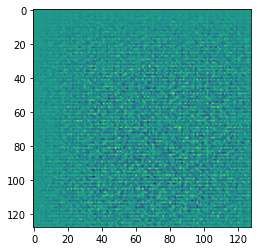

In [7]:
noise = tf.random.normal([1,SEED_SIZE])

generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0])

image_shape = (HEIGHT, HEIGHT, IMAGE_CHANNELS)

print(discriminator(generated_image))


In [8]:
# generator_optimizer = tf.keras.optimizers.Adam(0.0002,0.5)
# discriminator_optimizer = tf.keras.optimizers.Adam(0.0002,0.5)

In [9]:
def generate_images(generated_images2):
    fig = plt.figure(figsize=(10,10))
    for i in range(1,21):
        fig.add_subplot(5,5,i)
        plt.imshow(generated_images2[i])
        plt.axis('off')
    plt.show()

In [10]:
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [11]:
from src.utils import image_dataset_from_directory
dir = "images/"
train_ds = image_dataset_from_directory(dir,
  seed=123,
  label_mode=None
  ,image_size=(128, 128), color_mode= "rgb",
  batch_size=BATCH_SIZE)

Found 8774 files belonging to 1 classes.


/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3504: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "


In [12]:
def process(image):
  image = tf.cast((image -127.5)/127.5 ,tf.float32)
  return image

train_ds = train_ds.map(process)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3504: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "


In [13]:
class GAN():
  def __init__(self):
    the_disc = Discriminator()
    the_gen = Generator()

    self.generator = the_gen.define_generator_model()
    self.generator_optimizer = the_gen.generator_opt()
    self.generator_losses = []

    self.discriminator = the_disc.define_discriminator_model()
    self.discriminator_optimizer = the_disc.discriminator_opt()
    self.discriminator_losses = []

    noise = Input(shape=(100,))
    img = self.generator(noise)
    valid, _ = self.discriminator(img)
    self.combined = Model(noise, valid)
    self.combined_opt = Adam(0.0002, 0.5)
    self.combined.compile(loss=['binary_crossentropy'], optimizer=self.combined_opt)
  
  @tf.function
  def train_step(self, images, batch_size, once):
    noise = tf.random.normal([batch_size, 100])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = self.generator(noise, training=True)

        real_output, _  = self.discriminator(images, training=True)
        
        fake_output, _  = self.discriminator(generated_images, training=True)
        
        if once:
            print(len(generated_images))
            print(type(generated_images))

            print(len(fake_output))
            print(type(fake_output))

            print(len(fake_output[0]))
            print(type(fake_output[0]))

            print(len(real_output))
            print(type(real_output))

            print(real_output[0])
            print(type(real_output[0]))
            once = False
        
        gen_loss = Generator().generator_loss(fake_output)
        disc_loss = Discriminator().discriminator_loss(real_output, fake_output)
    
    gradients_of_generator = gen_tape.gradient(gen_loss, self.generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, self.discriminator.trainable_variables)
    
    self.discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, self.discriminator.trainable_variables))
    self.generator_optimizer.apply_gradients(zip(gradients_of_generator, self.generator.trainable_variables))

    return gen_loss , disc_loss ,generated_images

  def train(self, epochs, batch_size, X=None, y=None, display_iter=10):
    for epoch in range(epochs):
        gen_loss_list = []
        disc_loss_list = []
        start = time.time()
        once = True

        for image_batch in (X):
            t =  self.train_step(image_batch, batch_size, once)
            once = False
            gen_loss_list.append(t[0])
            disc_loss_list.append(t[1])
        
        # Produce images for the GIF as you go
        # display.clear_output(wait=True)
        g_loss = sum(gen_loss_list) / len(gen_loss_list) #calculate losses
        d_loss = sum(disc_loss_list) / len(disc_loss_list)
        
        generate_images(t[2])
        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))
        
        print(f'Epoch {epoch+1}, gen loss = {g_loss}, disc loss = {d_loss}')
        self.generator_losses.append(g_loss)
        self.discriminator_losses.append(d_loss)

    
  # Generate after the final epoch
  display.clear_output(wait=True)

In [14]:
gan = GAN()

128
<class 'tensorflow.python.framework.ops.EagerTensor'>
128
<class 'tensorflow.python.framework.ops.EagerTensor'>
1
<class 'tensorflow.python.framework.ops.EagerTensor'>
128
<class 'tensorflow.python.framework.ops.EagerTensor'>
tf.Tensor([[[0.5001121]]], shape=(1, 1, 1), dtype=float32)
<class 'tensorflow.python.framework.ops.EagerTensor'>


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

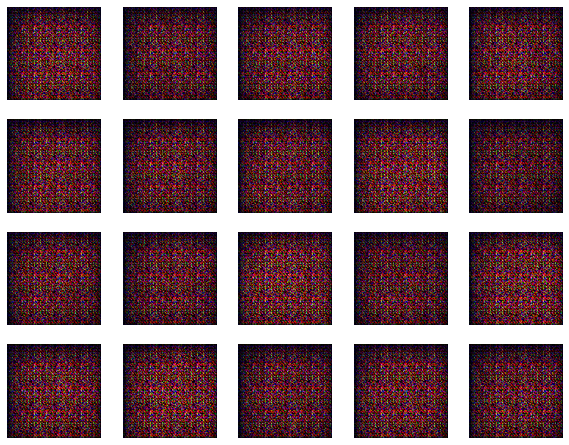

Time for epoch 1 is 5806.5764129161835 sec
Epoch 1, gen loss = 0.7641879916191101, disc loss = 1.3373221158981323
128
<class 'tensorflow.python.framework.ops.EagerTensor'>
128
<class 'tensorflow.python.framework.ops.EagerTensor'>
1
<class 'tensorflow.python.framework.ops.EagerTensor'>
128
<class 'tensorflow.python.framework.ops.EagerTensor'>
tf.Tensor([[[0.6393227]]], shape=(1, 1, 1), dtype=float32)
<class 'tensorflow.python.framework.ops.EagerTensor'>


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

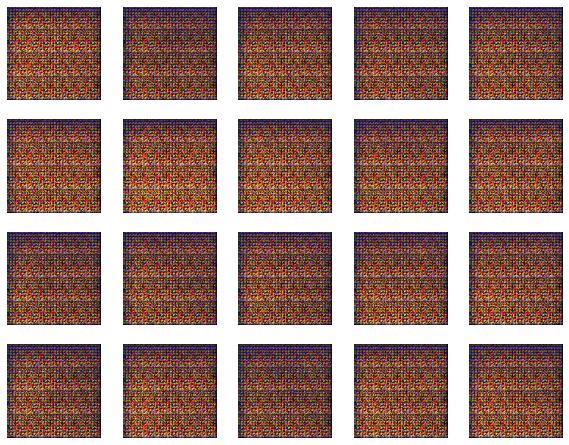

Time for epoch 2 is 1132.1971364021301 sec
Epoch 2, gen loss = 1.2218468189239502, disc loss = 0.8713233470916748
128
<class 'tensorflow.python.framework.ops.EagerTensor'>
128
<class 'tensorflow.python.framework.ops.EagerTensor'>
1
<class 'tensorflow.python.framework.ops.EagerTensor'>
128
<class 'tensorflow.python.framework.ops.EagerTensor'>
tf.Tensor([[[1.]]], shape=(1, 1, 1), dtype=float32)
<class 'tensorflow.python.framework.ops.EagerTensor'>


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

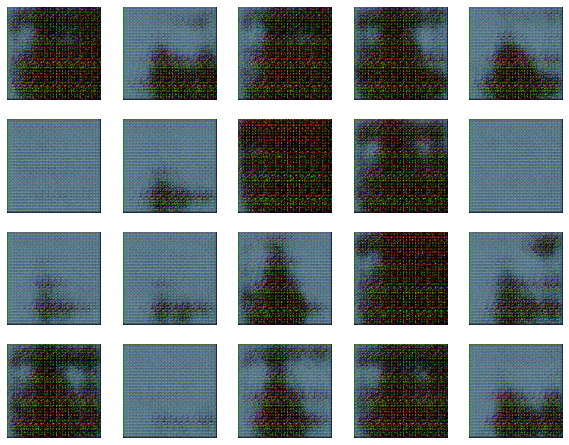

Time for epoch 3 is 1130.7638511657715 sec
Epoch 3, gen loss = 0.9814541339874268, disc loss = 1.2204574346542358
128
<class 'tensorflow.python.framework.ops.EagerTensor'>
128
<class 'tensorflow.python.framework.ops.EagerTensor'>
1
<class 'tensorflow.python.framework.ops.EagerTensor'>
128
<class 'tensorflow.python.framework.ops.EagerTensor'>
tf.Tensor([[[0.95806426]]], shape=(1, 1, 1), dtype=float32)
<class 'tensorflow.python.framework.ops.EagerTensor'>


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

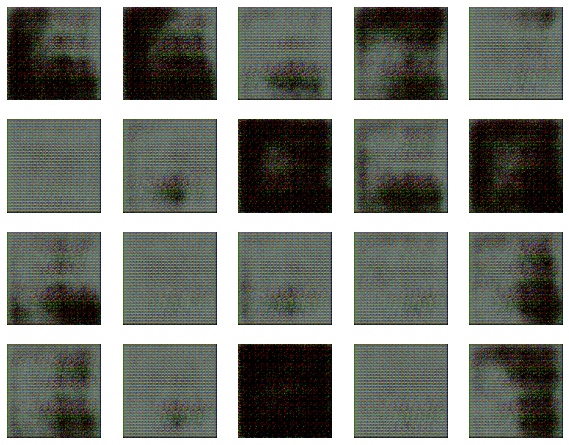

Time for epoch 4 is 1133.8815460205078 sec
Epoch 4, gen loss = 0.7878185510635376, disc loss = 1.3404808044433594
128
<class 'tensorflow.python.framework.ops.EagerTensor'>
128
<class 'tensorflow.python.framework.ops.EagerTensor'>
1
<class 'tensorflow.python.framework.ops.EagerTensor'>
128
<class 'tensorflow.python.framework.ops.EagerTensor'>
tf.Tensor([[[0.4885399]]], shape=(1, 1, 1), dtype=float32)
<class 'tensorflow.python.framework.ops.EagerTensor'>


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

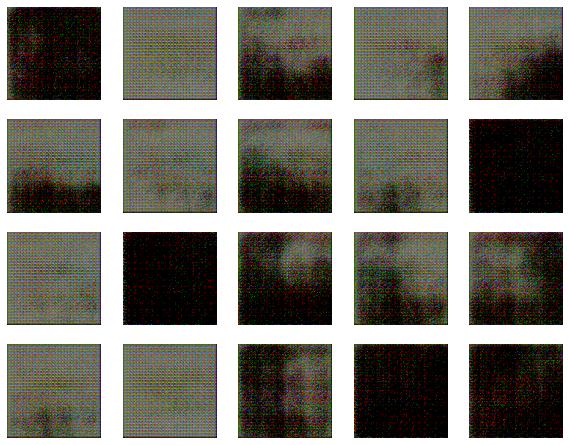

Time for epoch 5 is 1135.6339635849 sec
Epoch 5, gen loss = 0.7470743656158447, disc loss = 1.3527356386184692
128
<class 'tensorflow.python.framework.ops.EagerTensor'>
128
<class 'tensorflow.python.framework.ops.EagerTensor'>
1
<class 'tensorflow.python.framework.ops.EagerTensor'>
128
<class 'tensorflow.python.framework.ops.EagerTensor'>
tf.Tensor([[[0.5450025]]], shape=(1, 1, 1), dtype=float32)
<class 'tensorflow.python.framework.ops.EagerTensor'>


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

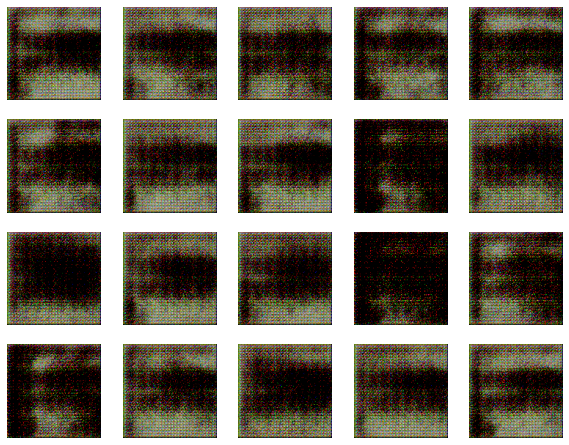

Time for epoch 6 is 1149.8436892032623 sec
Epoch 6, gen loss = 0.7724694609642029, disc loss = 1.3445006608963013
128
<class 'tensorflow.python.framework.ops.EagerTensor'>
128
<class 'tensorflow.python.framework.ops.EagerTensor'>
1
<class 'tensorflow.python.framework.ops.EagerTensor'>
128
<class 'tensorflow.python.framework.ops.EagerTensor'>
tf.Tensor([[[0.9988067]]], shape=(1, 1, 1), dtype=float32)
<class 'tensorflow.python.framework.ops.EagerTensor'>


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

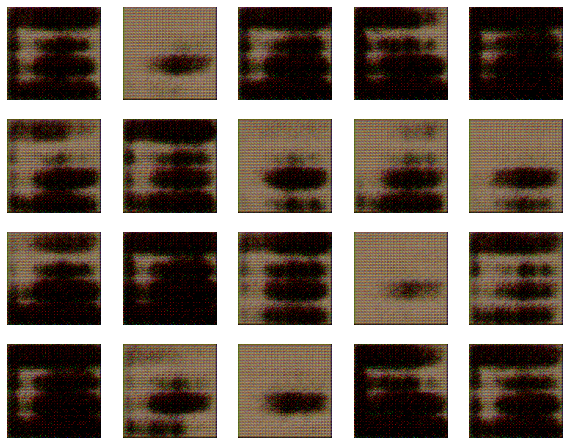

Time for epoch 7 is 1117.7758347988129 sec
Epoch 7, gen loss = 0.7737028002738953, disc loss = 1.359582543373108
128
<class 'tensorflow.python.framework.ops.EagerTensor'>
128
<class 'tensorflow.python.framework.ops.EagerTensor'>
1
<class 'tensorflow.python.framework.ops.EagerTensor'>
128
<class 'tensorflow.python.framework.ops.EagerTensor'>
tf.Tensor([[[0.54693943]]], shape=(1, 1, 1), dtype=float32)
<class 'tensorflow.python.framework.ops.EagerTensor'>


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

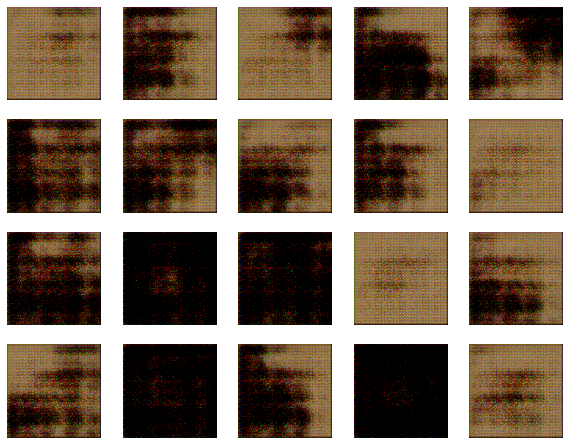

Time for epoch 8 is 1137.7388927936554 sec
Epoch 8, gen loss = 0.8240237236022949, disc loss = 1.3224107027053833
128
<class 'tensorflow.python.framework.ops.EagerTensor'>
128
<class 'tensorflow.python.framework.ops.EagerTensor'>
1
<class 'tensorflow.python.framework.ops.EagerTensor'>
128
<class 'tensorflow.python.framework.ops.EagerTensor'>
tf.Tensor([[[0.47471175]]], shape=(1, 1, 1), dtype=float32)
<class 'tensorflow.python.framework.ops.EagerTensor'>


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

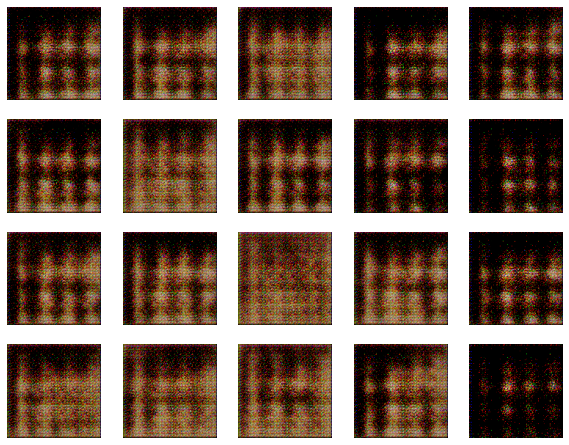

Time for epoch 9 is 1122.2090458869934 sec
Epoch 9, gen loss = 0.7241593599319458, disc loss = 1.3785279989242554
128
<class 'tensorflow.python.framework.ops.EagerTensor'>
128
<class 'tensorflow.python.framework.ops.EagerTensor'>
1
<class 'tensorflow.python.framework.ops.EagerTensor'>
128
<class 'tensorflow.python.framework.ops.EagerTensor'>
tf.Tensor([[[0.4981947]]], shape=(1, 1, 1), dtype=float32)
<class 'tensorflow.python.framework.ops.EagerTensor'>


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

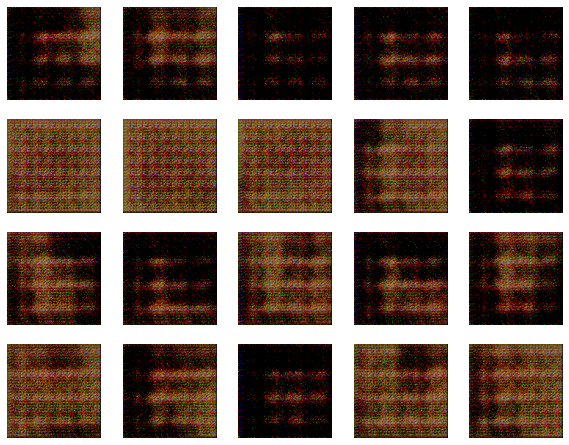

Time for epoch 10 is 1104.6329374313354 sec
Epoch 10, gen loss = 0.745526134967804, disc loss = 1.3412939310073853


In [15]:
import matplotlib.pyplot as plt
gan.train(X=train_ds, y=train_ds, epochs=10, batch_size=BATCH_SIZE, display_iter=2)
